In [1]:
%load_ext tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Helper functions

In [3]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['valid'] = Subset(dataset, val_idx)
    return datasets

In [4]:
def train_and_validate(model, loss_criterion, optimizer, epochs, train_data_loader, valid_data_loader, device):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    writer = SummaryWriter()
    model = model.to(device)
    start = time.time()
    history = []
    best_loss = np.inf   # init to infinity

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs.cuda())

            #print(f"Output shape: {outputs.shape} \t Label shape: {labels.shape}")
            
            # Compute loss
            loss = loss_criterion(outputs, labels) #.to(torch.float32)
            
            #print(f"Outputs: {outputs} \t type: {outputs.dtype}")
            #print(f"Loss: {loss} \t type: {loss.dtype}")
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            

            # Compute the accuracy
            #ret, predictions = torch.max(outputs.data, 1)
            #correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            #acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            #train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        writer.add_scalar("Train_loss x epoch", train_loss/len(train_data_loader), epoch)
        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs.cuda())

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                #ret, predictions = torch.max(outputs.data, 1)
                #correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                #acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                #valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        writer.add_scalar("Valid_loss x epoch", valid_loss/len(valid_data_loader), epoch)
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data_loader) 
        #avg_train_acc = train_acc/train_data_size
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(valid_data_loader) 
        #avg_valid_acc = valid_acc/valid_data_size
        
        history.append([avg_train_loss, avg_valid_loss])#, avg_train_acc, avg_valid_acc])        
        epoch_end = time.time()
        if avg_valid_loss < best_loss:
            print("New best model saved")
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), 'custom_model_bw.pt')
            
        #print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        print("Epoch : {:03d}, Training: Loss: {:.4f}, \n\t\tValidation : Loss : {:.4f}, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_valid_loss, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
    writer.close()      
    return model, history

# Preparing Custom Dataset

In [5]:
# Custom datasets for each shape
class FigureImageDataset(Dataset):
    def __init__(self, figure, annotations_file, img_dir, transform=None, target_transform=None):
        self.figure = figure
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.figure + "_img_" + str(self.img_labels.iloc[idx, 0]) + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path).float()
        label = np.round(self.img_labels.iloc[idx, 1:4].to_numpy(), 1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
# Dataset: imgs and labels paths
dataset_path = "/home/corcasta/Documents/ati/dataset"

# Images dir
square_imgs_dir = dataset_path + "/images/square"
sphere_imgs_dir = dataset_path + "/images/sphere"
romboid_imgs_dir = dataset_path + "/images/romboid"
square_inv_imgs_dir = dataset_path + "/images/square_inv"
romboid_inv_imgs_dir = dataset_path + "/images/romboid_inv"
zero_force_imgs_dir = dataset_path + "/images/zero_force"

# Labels dir
square_labels_dir = dataset_path + "/labels/square"
sphere_labels_dir = dataset_path + "/labels/sphere"
romboid_labels_dir = dataset_path + "/labels/romboid"
square_inv_labels_dir = dataset_path + "/labels/square_inv"
romboid_inv_labels_dir = dataset_path + "/labels/romboid_inv"
zero_force_labels_dir = dataset_path + "/labels/zero_force"

# Files
square_labels_file = square_labels_dir + "/square_data.csv"
sphere_labels_file = sphere_labels_dir + "/sphere_data.csv"
romboid_labels_file = romboid_labels_dir + "/romboid_data.csv"
square_inv_labels_file = square_inv_labels_dir + "/square_inv_data.csv"
romboid_inv_labels_file = romboid_inv_labels_dir + "/romboid_inv_data.csv"
zero_force_labels_file = zero_force_labels_dir + "/zero_force_data.csv"

In [7]:
files_list = [
    square_labels_file,
    sphere_labels_file,
    romboid_labels_file,
    square_inv_labels_file,
    romboid_inv_labels_file,
    zero_force_labels_file    
]

total_df = pd.DataFrame(columns=['Unnamed: 0', 'fx', 'fy', 'fz', 'x', 'y', 'z', 'x_shear', 'y_shear'])

for file in files_list:
    df = pd.read_csv(file)
    print(len(df))
    #total_df = pd.concat([total_df, df], ignore_index=True)

5401
985
3505
4429
3937
1991


In [8]:
len(pd.read_csv(square_labels_file))

5401

In [9]:
# Loading individual datasets
square_dataset = FigureImageDataset("square", annotations_file=square_labels_file, img_dir=square_imgs_dir)
romboid_dataset = FigureImageDataset("romboid", annotations_file=romboid_labels_file, img_dir=romboid_imgs_dir)
zero_force_dataset = FigureImageDataset("zero_force", annotations_file=zero_force_labels_file, img_dir=zero_force_imgs_dir)

square_inv_dataset = FigureImageDataset("square_inv", annotations_file=square_inv_labels_file, img_dir=square_inv_imgs_dir)
romboid_inv_dataset = FigureImageDataset("romboid_inv", annotations_file=romboid_inv_labels_file, img_dir=romboid_inv_imgs_dir)
zero_force_dataset = FigureImageDataset("zero_force", annotations_file=zero_force_labels_file, img_dir=zero_force_imgs_dir)

                                     
# Dataset containing square and sphere imgs including labels
full_dataset = ConcatDataset([square_dataset, romboid_dataset, square_inv_dataset, romboid_inv_dataset, zero_force_dataset])
split_datasets = train_val_dataset(full_dataset)

(array([  2. ,  -0.3, -14. ]),
 torch.float32)

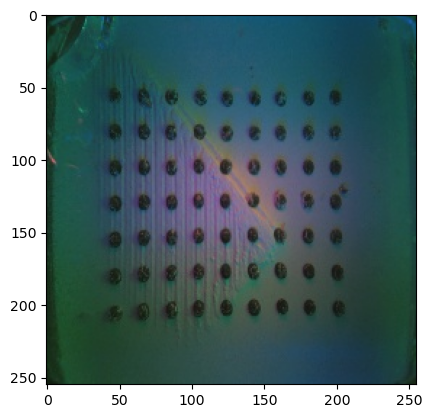

In [10]:
# Making sure everything load properly
img, label = full_dataset[7150]
label, plt.imshow(img.int().permute(1,2,0)), img.dtype

In [11]:
img

tensor([[[19., 19., 24.,  ..., 28., 30., 27.],
         [17., 19., 21.,  ..., 24., 28., 23.],
         [13., 17., 17.,  ..., 18., 23., 19.],
         ...,
         [18., 18., 18.,  ..., 27., 24., 20.],
         [17., 18., 18.,  ..., 24., 23., 22.],
         [18., 19., 19.,  ..., 23., 25., 24.]],

        [[32., 30., 33.,  ..., 75., 77., 72.],
         [31., 32., 32.,  ..., 72., 74., 67.],
         [34., 35., 31.,  ..., 69., 68., 57.],
         ...,
         [30., 32., 32.,  ..., 45., 41., 36.],
         [29., 30., 30.,  ..., 42., 40., 36.],
         [29., 30., 30.,  ..., 41., 39., 37.]],

        [[14., 13., 16.,  ..., 41., 41., 33.],
         [14., 15., 16.,  ..., 46., 45., 32.],
         [17., 19., 16.,  ..., 62., 48., 32.],
         ...,
         [16., 17., 17.,  ..., 31., 25., 23.],
         [15., 16., 16.,  ..., 26., 24., 21.],
         [15., 16., 16.,  ..., 25., 22., 20.]]])

# Creating Model Architecture

In [12]:
class MyNet(nn.Module):
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(25088, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64 ,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(30752,1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,3)
            )
    
    def forward(self, xb):
        return self.network(xb)
    

# Creating Custom Loss Function

In [13]:
class MyMSELoss(nn.Module):
    def __init__(self):
        super(MyMSELoss, self).__init__()

    def forward(self, inputs, targets):
        # Calculate the loss for each ourput neuron
        # in this case 3 losses one for each force
        individual_force_mean_square = ((inputs - targets)**2).mean(0)
        loss = individual_force_mean_square.mean()
        return loss

# Training Model

In [14]:
# Choose whatever GPU device number you want
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Epochs
num_epochs = 50

# bath size
bs = 16

train_data_loader = DataLoader(split_datasets["train"], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(split_datasets["valid"], batch_size=bs, shuffle=True)

# Model instance
model = MyNet()
#model = models.vgg16(pretrained=True)

"""
model.classifier[-1] = nn.Linear(4096, 3) # Change the final layer of AlexNet Model for Transfer Learning
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer parameters
for param in model.classifier.parameters():
    param.requires_grad = True
"""

# loss function and optimizer
loss_fn = MyMSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [15]:
print(model)

MyNet(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=30752, out_features=1024, bias=True)
    (17): Dropout(p=0.5, inplace=False)
    (18): ReLU(

In [16]:
trained_model, history = train_and_validate(model, loss_fn, optimizer, num_epochs, train_data_loader, valid_data_loader, device)

Epoch: 1/50
New best model saved
Epoch : 001, Training: Loss: 180.1651, 
		Validation : Loss : 99.0124, Time: 88.0683s
Epoch: 2/50
New best model saved
Epoch : 002, Training: Loss: 103.0960, 
		Validation : Loss : 88.0127, Time: 88.0506s
Epoch: 3/50
Epoch : 003, Training: Loss: 91.7578, 
		Validation : Loss : 94.8869, Time: 87.9168s
Epoch: 4/50
New best model saved
Epoch : 004, Training: Loss: 88.8642, 
		Validation : Loss : 80.4501, Time: 87.8467s
Epoch: 5/50
New best model saved
Epoch : 005, Training: Loss: 84.0395, 
		Validation : Loss : 76.3751, Time: 88.0269s
Epoch: 6/50
New best model saved
Epoch : 006, Training: Loss: 78.7043, 
		Validation : Loss : 73.0312, Time: 87.8026s
Epoch: 7/50
New best model saved
Epoch : 007, Training: Loss: 74.3387, 
		Validation : Loss : 71.8502, Time: 88.1300s
Epoch: 8/50
Epoch : 008, Training: Loss: 72.3444, 
		Validation : Loss : 74.0660, Time: 87.8216s
Epoch: 9/50
New best model saved
Epoch : 009, Training: Loss: 69.0456, 
		Validation : Loss : 70

KeyboardInterrupt: 

# Evaluate Model

In [36]:
model2 = MyNet()
model2.load_state_dict(torch.load("output_3f_bw.pt", map_location=torch.device('cpu')))
model2.eval()

MyNet(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=30752, out_features=1024, bias=True)
    (17): Dropout(p=0.5, inplace=False)
    (18): ReLU(

In [154]:
img, label = split_datasets["valid"][2710]
label

array([0., 0., 0.])

In [155]:
img.shape

torch.Size([3, 255, 255])

In [48]:

predicted_output = model2(dummy)

In [49]:
print(f"Output: {label}")
print(f"Predicted Output: {predicted_output}")

Output: [0. 0. 0.]
Predicted Output: tensor([[ 0.0504,  0.0790, -0.0817]], grad_fn=<AddmmBackward0>)


In [161]:
def pixel_diff_filter(input_img, ref_img, threshold=2.0):
    """
    ref_img: type string, path to reference image 
    threshold: type float, currently set to 2.0 given experiment results

    If the pixel difference is higher than threshold then input the image to NN
    else the predicted label for forces must be set to [0., 0., 0.]

    returns bool
    """
    if (ref_img-input_img).abs().mean() < 1.9:          
        return True
    else:
        return False

In [170]:
ref_img = torchvision.io.read_image("reference.jpg").float() # Reference img needed for filtering forces
output_list = []
predicted_output_list = []
for sample in split_datasets["valid"]:
    img, label = sample
    if pixel_diff_filter(img, ref_img):
        output_list.append(label)
        predicted_output = np.array([[0.0, 0.0, 0.0]])
        predicted_output_list.append(predicted_output)
    else:
        output_list.append(label)
        img = img[None, :, :, :]
        predicted_output = model2(img)
        predicted_output_list.append(predicted_output.numpy(force=True))

In [171]:
output_list = np.asarray(output_list)
predicted_output_list = np.round(np.asarray(predicted_output_list),1).squeeze()

# Plotting Results

In [172]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

In [173]:
plt.rcParams['figure.figsize'] = [20, 5]

Text(0.5, 1.0, 'Fz (Normal Force)')

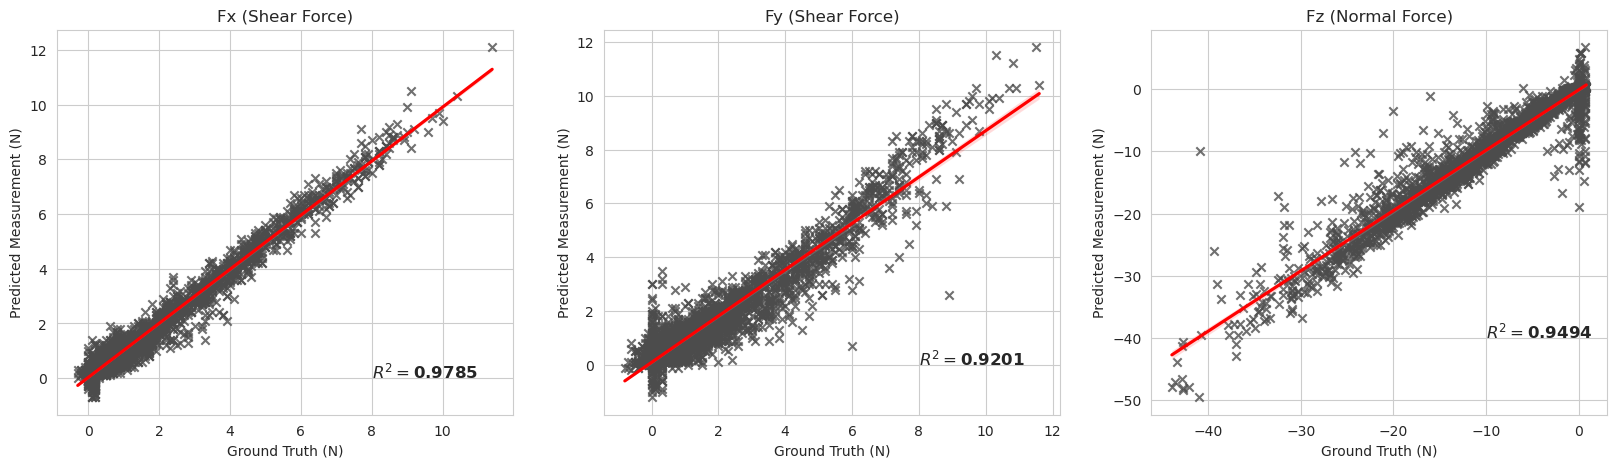

In [174]:
sns.set_style('whitegrid') 

viz_df = pd.DataFrame({
    "fx_gt": output_list[:,0],
    "fy_gt": output_list[:,1],
    "fz_gt": output_list[:,2],
    "fx_pred": predicted_output_list[:,0],
    "fy_pred": predicted_output_list[:,1],
    "fz_pred": predicted_output_list[:,2],
})

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = sns.regplot(x="fx_gt", y="fx_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[0])
r2 = r2_score(viz_df["fx_gt"], viz_df["fx_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[0].set_xlabel("Ground Truth (N)")
axs[0].set_ylabel("Predicted Measurement (N)")
axs[0].set_title("Fx (Shear Force)")



ax = sns.regplot(x="fy_gt", y="fy_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[1])
r2 = r2_score(viz_df["fy_gt"], viz_df["fy_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[1].set_xlabel("Ground Truth (N)")
axs[1].set_ylabel("Predicted Measurement (N)")
axs[1].set_title("Fy (Shear Force)")


ax = sns.regplot(x="fz_gt", y="fz_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[2])
r2 = r2_score(viz_df["fz_gt"], viz_df["fz_pred"])
ax.text(-10, -40, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[2].set_xlabel("Ground Truth (N)")
axs[2].set_ylabel("Predicted Measurement (N)")
axs[2].set_title("Fz (Normal Force)")



In [212]:
viz_df[(viz_df["fz_gt"]==0) & 
      (viz_df["fz_pred"]>-20) &
      (viz_df["fz_pred"]<-1)]

,fx_gt,fy_gt,fz_gt,fx_pred,fy_pred,fz_pred
162,0.0,-0.0,-0.0,0.0,-0.3,-2.4
248,0.0,-0.0,-0.0,0.1,1.2,-1.1
439,0.0,-0.0,-0.0,0.1,0.2,-2.3
471,-0.0,-0.0,-0.0,0.3,0.1,-1.2
664,0.0,-0.0,-0.0,0.8,0.3,-10.7
716,0.0,-0.0,-0.0,0.1,1.9,-4.0
760,-0.0,-0.0,-0.0,0.5,1.2,-2.9
842,0.0,-0.0,-0.0,0.6,1.2,-10.3
876,-0.0,-0.0,-0.0,0.5,3.0,-7.1
964,0.0,-0.0,-0.0,0.1,0.3,-11.6


In [213]:
img_inv, label_inv = split_datasets["valid"][964]

In [214]:
img_inv, label_inv

(tensor([[[16., 16., 19.,  ..., 28., 22., 16.],
          [19., 17., 15.,  ..., 21., 19., 18.],
          [16., 19., 22.,  ..., 16., 16., 17.],
          ...,
          [19., 20., 18.,  ..., 24., 23., 23.],
          [21., 20., 18.,  ..., 21., 21., 21.],
          [22., 23., 19.,  ..., 22., 24., 25.]],
 
         [[33., 33., 32.,  ..., 57., 54., 55.],
          [33., 31., 29.,  ..., 53., 52., 53.],
          [28., 33., 36.,  ..., 54., 49., 45.],
          ...,
          [29., 31., 32.,  ..., 42., 40., 37.],
          [29., 30., 30.,  ..., 38., 35., 34.],
          [27., 30., 29.,  ..., 39., 39., 38.]],
 
         [[15., 15., 15.,  ..., 37., 30., 28.],
          [18., 14., 14.,  ..., 40., 33., 29.],
          [16., 18., 23.,  ..., 57., 40., 30.],
          ...,
          [18., 17., 17.,  ..., 28., 24., 22.],
          [18., 19., 18.,  ..., 22., 18., 17.],
          [20., 22., 20.,  ..., 21., 20., 20.]]]),
 array([ 0., -0., -0.]))

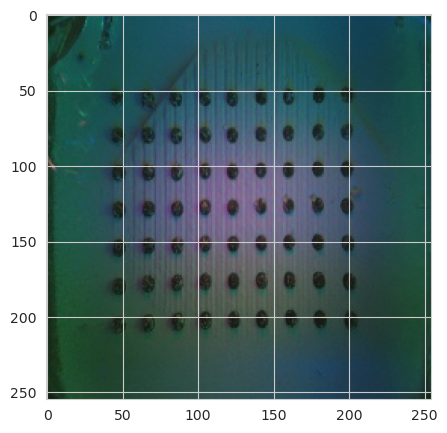

In [215]:
plt.imshow(img_inv.int().permute(1,2,0))

Text(0.5, 1.0, 'Fz (Normal Force)')

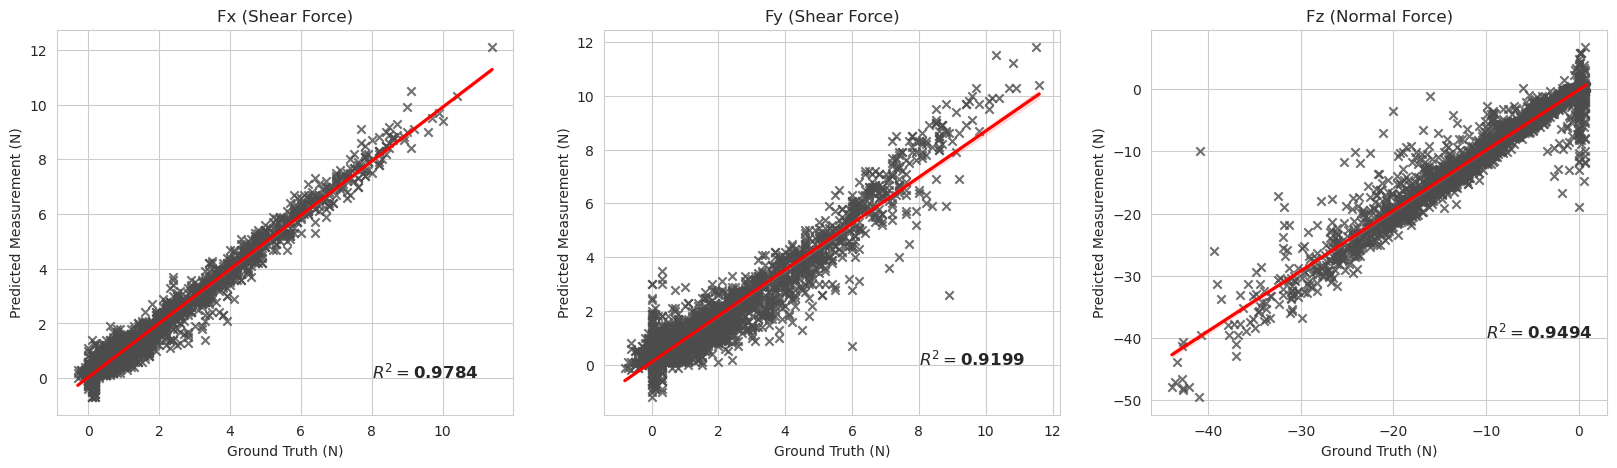

In [58]:
sns.set_style('whitegrid') 

viz_df = pd.DataFrame({
    "fx_gt": output_list[:,0],
    "fy_gt": output_list[:,1],
    "fz_gt": output_list[:,2],
    "fx_pred": predicted_output_list[:,0],
    "fy_pred": predicted_output_list[:,1],
    "fz_pred": predicted_output_list[:,2],
})

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = sns.regplot(x="fx_gt", y="fx_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[0])
r2 = r2_score(viz_df["fx_gt"], viz_df["fx_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[0].set_xlabel("Ground Truth (N)")
axs[0].set_ylabel("Predicted Measurement (N)")
axs[0].set_title("Fx (Shear Force)")



ax = sns.regplot(x="fy_gt", y="fy_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[1])
r2 = r2_score(viz_df["fy_gt"], viz_df["fy_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[1].set_xlabel("Ground Truth (N)")
axs[1].set_ylabel("Predicted Measurement (N)")
axs[1].set_title("Fy (Shear Force)")


ax = sns.regplot(x="fz_gt", y="fz_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[2])
r2 = r2_score(viz_df["fz_gt"], viz_df["fz_pred"])
ax.text(-10, -40, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[2].set_xlabel("Ground Truth (N)")
axs[2].set_ylabel("Predicted Measurement (N)")
axs[2].set_title("Fz (Normal Force)")



In [59]:
import cv2

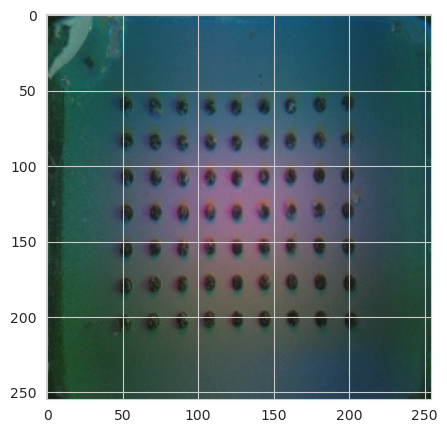

In [156]:
ref_img = cv2.imread("reference.jpg")
plt.imshow(ref_img)



plt.imshow(ref_img.int().permute(1,2,0))

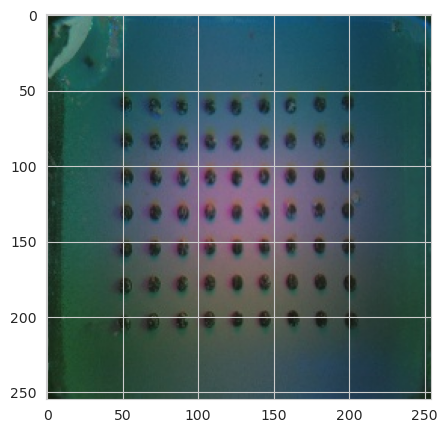

In [157]:
plt.imshow(img.int().permute(1,2,0))

tensor(1.7309)

In [107]:
img

tensor([[[17., 23., 26.,  ..., 24., 24., 21.],
         [23., 21., 21.,  ..., 26., 26., 22.],
         [18., 18., 22.,  ..., 26., 26., 23.],
         ...,
         [23., 20., 18.,  ..., 21., 19., 20.],
         [22., 18., 19.,  ..., 21., 20., 21.],
         [20., 17., 19.,  ..., 24., 23., 23.]],

        [[31., 37., 37.,  ..., 58., 56., 51.],
         [37., 35., 33.,  ..., 59., 58., 50.],
         [34., 35., 35.,  ..., 57., 54., 47.],
         ...,
         [31., 31., 30.,  ..., 38., 36., 34.],
         [30., 29., 30.,  ..., 38., 37., 35.],
         [31., 28., 29.,  ..., 41., 40., 37.]],

        [[18., 24., 23.,  ..., 34., 33., 27.],
         [24., 22., 19.,  ..., 38., 35., 27.],
         [21., 19., 18.,  ..., 41., 32., 25.],
         ...,
         [18., 17., 16.,  ..., 22., 18., 17.],
         [17., 15., 16.,  ..., 20., 19., 18.],
         [17., 14., 18.,  ..., 25., 24., 20.]]])

Text(0.5, 1.0, 'Fz (Normal Force)')

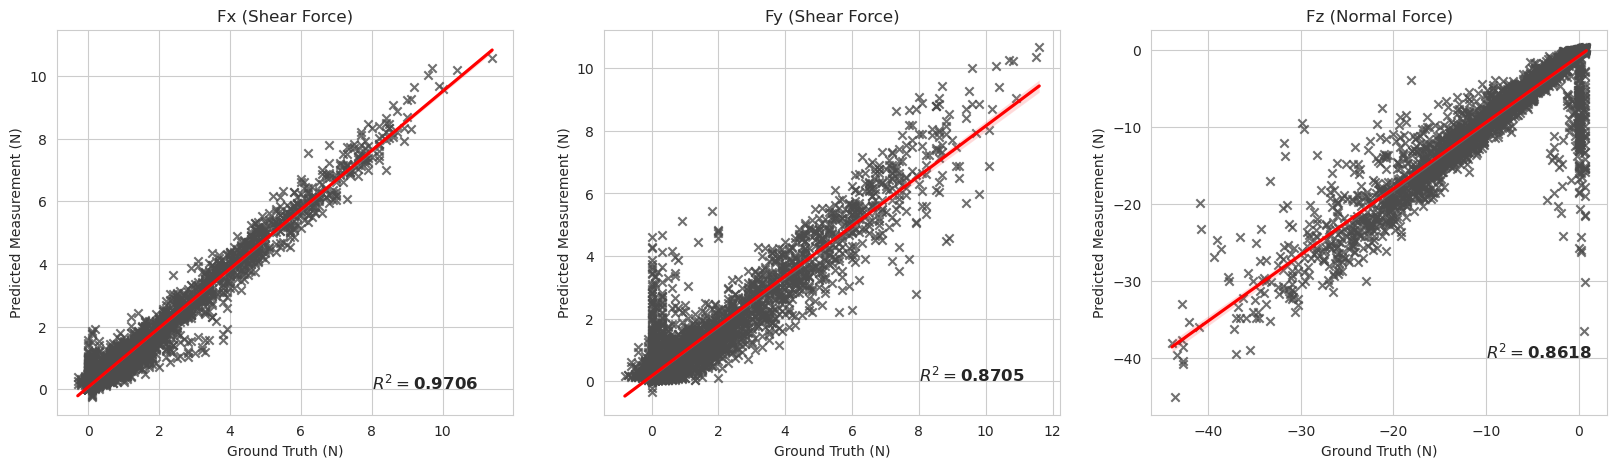

In [35]:
sns.set_style('whitegrid') 

viz_df = pd.DataFrame({
    "fx_gt": output_list[:,0],
    "fy_gt": output_list[:,1],
    "fz_gt": output_list[:,2],
    "fx_pred": predicted_output_list[:,0],
    "fy_pred": predicted_output_list[:,1],
    "fz_pred": predicted_output_list[:,2],
})

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = sns.regplot(x="fx_gt", y="fx_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[0])
r2 = r2_score(viz_df["fx_gt"], viz_df["fx_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[0].set_xlabel("Ground Truth (N)")
axs[0].set_ylabel("Predicted Measurement (N)")
axs[0].set_title("Fx (Shear Force)")



ax = sns.regplot(x="fy_gt", y="fy_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[1])
r2 = r2_score(viz_df["fy_gt"], viz_df["fy_pred"])
ax.text(8, 0, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[1].set_xlabel("Ground Truth (N)")
axs[1].set_ylabel("Predicted Measurement (N)")
axs[1].set_title("Fy (Shear Force)")


ax = sns.regplot(x="fz_gt", y="fz_pred", data=viz_df, ci=99, marker="x", color=".3", line_kws=dict(color="r"), ax=axs[2])
r2 = r2_score(viz_df["fz_gt"], viz_df["fz_pred"])
ax.text(-10, -40, r'$R^2 =$' + str(round(r2,4)), weight="bold",fontsize=12)
axs[2].set_xlabel("Ground Truth (N)")
axs[2].set_ylabel("Predicted Measurement (N)")
axs[2].set_title("Fz (Normal Force)")



# Data exploration

In [172]:
df = pd.read_csv(romboid_labels_file)
df[["fx", "fy", "fz"]] = np.round(df[["fx", "fy", "fz"]], 1)

In [173]:
df.head()

,Unnamed: 0,fx,fy,fz,x,y,z,x_shear,y_shear
0,0,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN
1,1,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,-0.1,0.0,0.0,1.3,0.0,0.0
3,3,0.0,0.1,-0.1,0.0,0.0,1.3,0.0,0.2
4,4,0.0,0.1,-0.1,0.0,0.0,1.3,0.0,0.5


array([[<Axes: title={'center': 'fx'}>, <Axes: title={'center': 'fy'}>],
       [<Axes: title={'center': 'fz'}>, <Axes: >]], dtype=object)

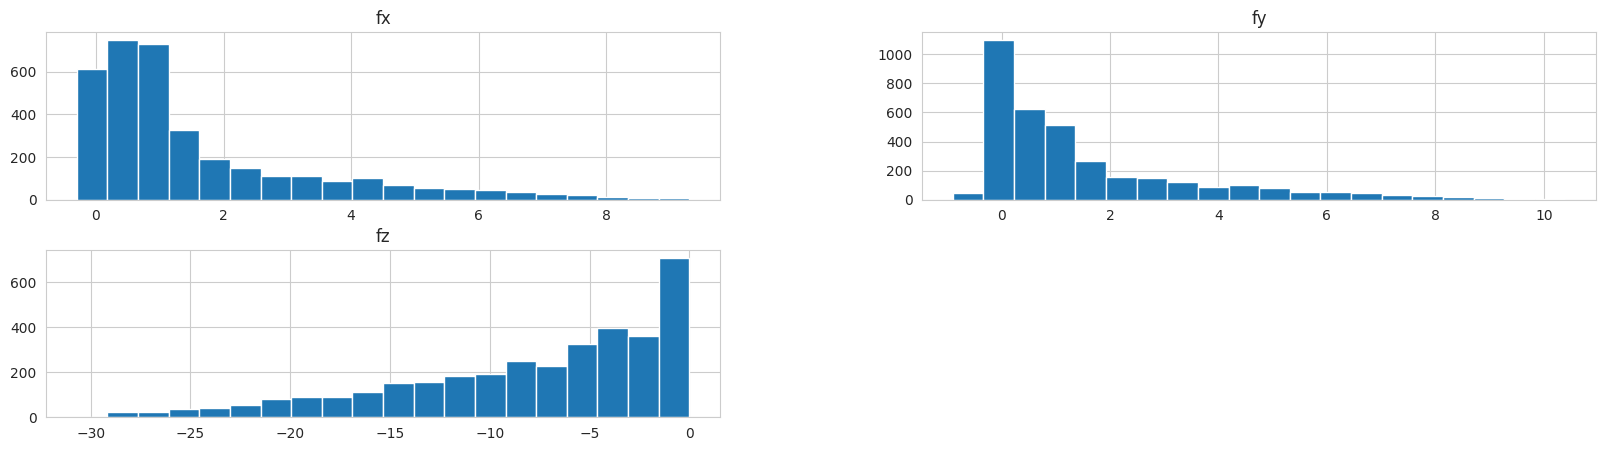

In [174]:
df[["fx", "fy", "fz"]].hist(bins=20)

array([[<Axes: title={'center': 'fx'}>, <Axes: title={'center': 'fy'}>],
       [<Axes: title={'center': 'fz'}>, <Axes: >]], dtype=object)

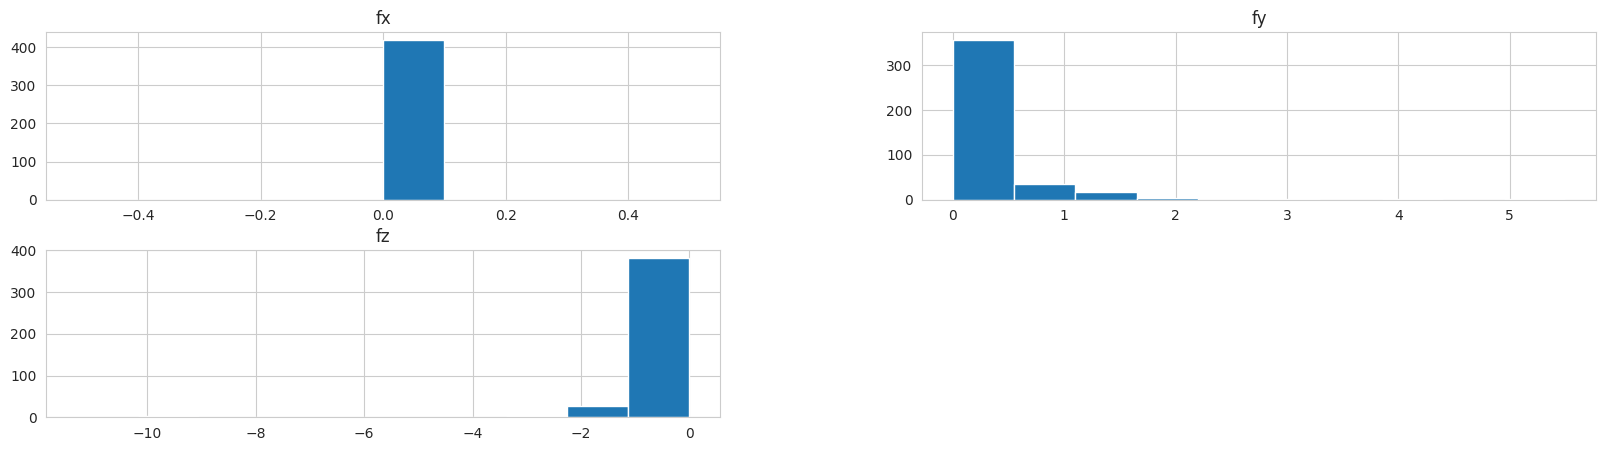

In [175]:
df.loc[(df["fx"]>=0) & (df["fx"] < 0.05)][["fx", "fy", "fz"]].hist()

array([[<Axes: title={'center': 'fx'}>, <Axes: title={'center': 'fy'}>],
       [<Axes: title={'center': 'fz'}>, <Axes: >]], dtype=object)

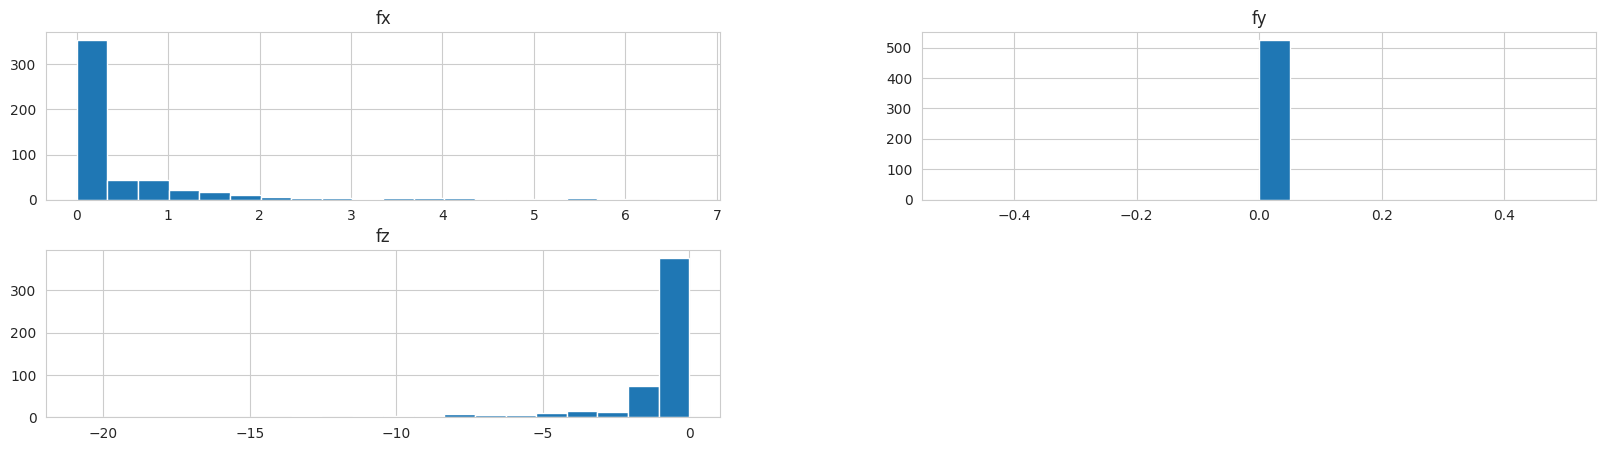

In [176]:
df.loc[(df["fy"]>=0) & (df["fy"] < 0.05)][["fx", "fy", "fz"]].hist(bins=20)

In [55]:
df.loc[(df["fz"]>=0) & (df["fz"] < 0.2)]#[["fx", "fy", "fz"]].hist()

,Unnamed: 0,fx,fy,fz,x,y,z,x_shear,y_shear
0,0,0.000955,0.000981,0.001218,0.0,0.0,0.0,NaN,NaN
1,1,-0.000465,0.000264,0.001550,0.0,0.0,0.0,0.0,0.0
83,83,0.013701,0.001142,0.025815,0.0,4.0,0.0,0.0,0.0
165,165,0.015236,0.009227,0.036102,0.0,8.0,0.0,0.0,0.0
247,247,0.030268,0.009000,0.047629,0.0,12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3905,3905,0.041269,0.104157,0.155220,20.0,28.0,1.7,0.0,1.1
3906,3906,0.106164,0.080990,0.060521,20.0,28.0,1.7,0.2,0.0
3907,3907,0.089156,0.080624,0.097456,20.0,28.0,1.7,0.5,0.0
3908,3908,0.075474,0.084449,0.125249,20.0,28.0,1.7,0.8,0.0
